In [45]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
import operator

load_dotenv()

True

In [46]:
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.2,
    max_output_tokens=1024,
    top_p=0.95,
    top_k=40,
    google_api_key=os.getenv("GEMINI_API_KEY") 
)

In [47]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive","negative"] = Field(description="The sentiment of the review")

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Feature Request", "Support", "Other"] = Field(description="The type of issue identified in the review")
    tone: Literal["neutral", "angry", "frustrated", "satisfied", "happy"] = Field(description="The tone of the review")
    urgency: Literal["low", "medium", "high"] = Field(description="The urgency of the issue")

structure_model = model.with_structured_output(SentimentSchema)
structure_model_diagnosis = model.with_structured_output(DiagnosisSchema)


In [48]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: str
    response: str


In [49]:
def find_sentiment(state: ReviewState):
    prompt = f'For the following review, determine if it is positive or negative:\n\n{state["review"]}\n\nRespond with "positive" or "negative".'
    response = structure_model.invoke(prompt).sentiment
    return {"sentiment": response}

def checksentiment(state: ReviewState) -> Literal["positive_response","run_diagonsis"]:
    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "run_diagonsis"
    
def positive_response(state: ReviewState):
    prompt = f'The review is positive. Respond with a thank you message.\n\n{state["review"]}\n\nRespond with a thank you message.'
    response = model.invoke(prompt).content

    return {"response": response}

def run_diagonsis(state: ReviewState):
    prompt = f'The review is negative. Run a diagnosis to understand the issue.\n\n{state["review"]}\n\nRespond with a diagnosis.'
    response = structure_model_diagnosis.invoke(prompt)

    return {"diagnosis": response.model_dump()} # JSON to dict conversion

def negative_response(state: ReviewState):
    diagnosis = state["diagnosis"]
    prompt = f'You are the support assistant. The user has the diagnosis {diagnosis["issue_type"]} with a tone of {diagnosis["tone"]} and urgency of {diagnosis["urgency"]}. Respond with an appropriate response.\n\n{state["review"]}\n\nRespond with a support message.'
    response = model.invoke(prompt).content

    return {'response': response}



In [50]:
graph = StateGraph(ReviewState)
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagonsis', run_diagonsis)
graph.add_node('negative_response', negative_response)


graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', checksentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagonsis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()



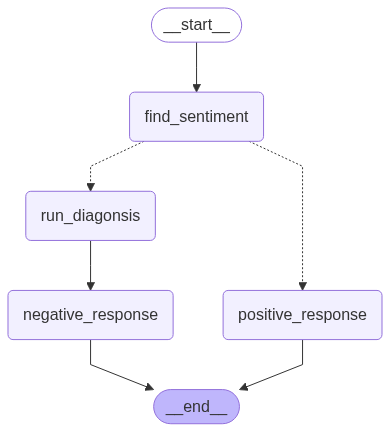

In [51]:
workflow 

In [52]:
initial_state = {
    'review': "The product is not working as expected. I am very disappointed with the service."
}

workflow.invoke(initial_state)

{'review': 'The product is not working as expected. I am very disappointed with the service.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'UX', 'tone': 'angry', 'urgency': 'high'},
 'response': "I understand your frustration and I sincerely apologize that the product isn't working as expected.  This is definitely not the experience we want you to have.  To help me resolve this quickly, could you please tell me more about what's happening?  Specifically:\n\n* **What exactly isn't working?**  Please describe the issue in as much detail as possible.  Include any error messages you're seeing.\n* **What steps have you already tried?**  This will help us avoid suggesting things you've already done.\n* **What version of the product are you using?** (If applicable)\n* **What device and operating system are you using?** (If applicable)\n\nThe more information you can provide, the faster we can get this resolved for you.  I'm committed to finding a solution and restoring your faith i